In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%config InlineBackend.figure_format = 'retina'
from DS_detector import rematch_cat

In [2]:
#df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
df = rematch_cat('/home/rt2122/Data/gen_cats/gen_all_found_brcat_prec0.00.csv', tp_dist=400/3600)
name='SZcat(gen)'

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
df = df[df['status'] != 'fp']
df = df[df['catalog'] != 'planck_no_z']
df.index = np.arange(len(df))

In [4]:
q_z = [df['z'].quantile(i/6) for i in range(0, 7)]
q_z[0] = 0
q_z[-1] = 2
q_m = [df['M500'].quantile(i/10) for i in range(0, 11)]
q_m[0] = 0
q_m[-1] = 20

In [5]:
q_m500 = {}
for i in range(len(q_z) - 1):
    st = q_z[i]
    en = q_z[i + 1]
    matched = np.logical_and(st <= df['z'], df['z'] < en)
    cur_df = df[matched]
    q_m500[en] = [cur_df['M500'].quantile(i / 10) for i in range(11)]
    q_m500[en][-1] = 20

In [6]:
q_m500 = pd.DataFrame(q_m500)
q_m500

,0.146000,0.276905,0.406467,0.545000,0.720816,2.000000
0,0.009600,0.309300,0.324500,0.472700,0.958000,1.282935
1,0.329700,1.041454,1.507556,1.663179,1.737631,1.715519
2,0.613820,1.520560,1.796266,1.904794,1.949375,1.881850
3,0.929140,1.829720,2.049589,2.101887,2.096046,2.037198
4,1.272120,2.168034,2.288912,2.293961,2.278848,2.155825
5,1.632600,2.603800,2.526098,2.488122,2.428041,2.297122
6,1.903060,3.170817,2.877972,2.682044,2.655300,2.440612
7,2.268199,3.775995,3.606200,2.953453,2.891080,2.690182
8,2.736071,4.357869,4.906258,3.500986,3.318380,2.973040
9,3.591454,5.313178,5.912650,4.956790,4.112285,3.522752


In [7]:
prm = 'mpp'
pred_ind_mean = []
for j in range(len(q_m500[q_z[1]]) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_m500[z_en][j]
        m_en = q_m500[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        pred_ind = cur_df[prm].mean()
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = pred_ind
    pred_ind_mean.append(pd.DataFrame(line, index=[j]))
pred_ind_mean = pd.concat(pred_ind_mean)

In [8]:
cm = sns.light_palette("green", as_cmap=True)

s = pred_ind_mean.style.background_gradient(cmap=cm)
s

,"(0.00,0.15)","(0.15,0.28)","(0.28,0.41)","(0.41,0.55)","(0.55,0.72)","(0.72,2.00)"
0,0.619847,0.604963,0.504347,0.467957,0.515906,0.542397
1,0.428684,0.559143,0.495144,0.566508,0.486723,0.513693
2,0.532763,0.608745,0.542653,0.506907,0.543460,0.431844
3,0.682353,0.635810,0.515430,0.519038,0.536004,0.525182
4,0.725189,0.625944,0.595814,0.488595,0.456885,0.467848
5,0.803123,0.701595,0.601754,0.547290,0.501551,0.445313
6,0.818775,0.817794,0.685997,0.571211,0.508587,0.530504
7,0.899099,0.918692,0.805977,0.594912,0.540805,0.531591
8,0.920146,0.981436,0.949988,0.706223,0.563298,0.575954
9,0.976649,0.989784,0.984901,0.913759,0.825729,0.655911


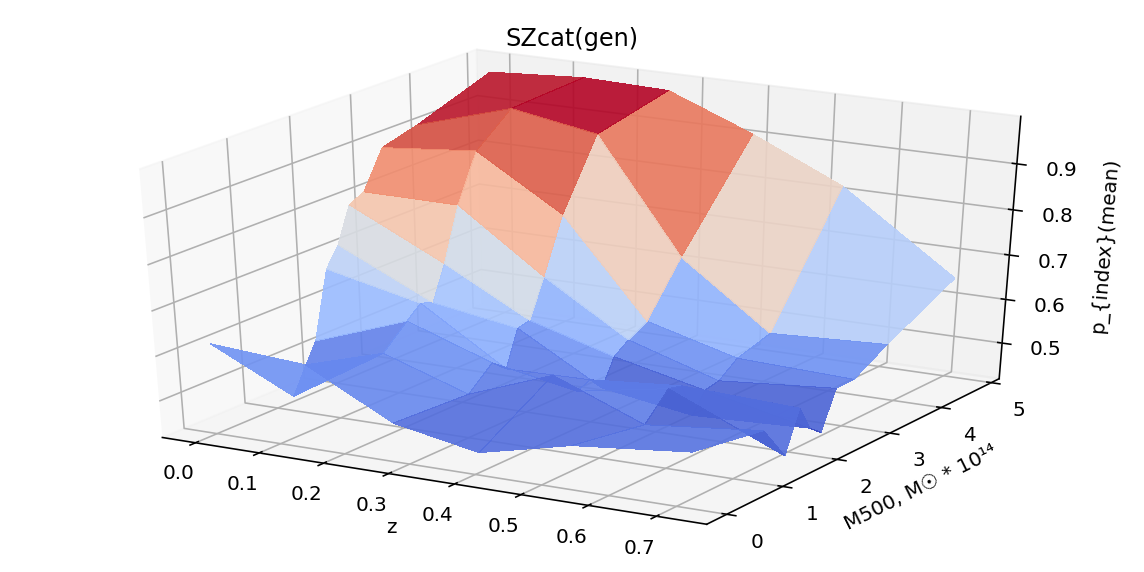

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))
X, Y = np.meshgrid(q_z[:-1], q_m[:-1])

Z = np.zeros_like(X)

ax.set_zticks(np.arange(0, 1.1, 0.1))
cols = list(pred_ind_mean)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = pred_ind_mean[cols[j]].iloc[i]
#X, Y = np.meshgrid(list(range(len(q_z) - 1)), list(range(len(q_m) - 1)))
        
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.9)

# Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('z')
ax.set_ylabel('M500, M☉ * 10¹⁴')
ax.set_zlabel('p_{index}(mean)')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title(name)
plt.show()